In [277]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import matplotlib
import geoplot
%matplotlib inline

# Read dataset
Day 0: Monday,..., Day5:Saturday, Day6: Sunday

In [2]:
df = pd.read_csv("../data/interim/aggregated.csv")

In [97]:
X_df = df.pivot(index='census', columns='timeslot', values='ped_count')
X_df.head()

timeslot,D0T00,D0T01,D0T02,D0T03,D0T04,D0T05,D0T06,D0T07,D0T08,D0T09,...,D6T14,D6T15,D6T16,D6T17,D6T18,D6T19,D6T20,D6T21,D6T22,D6T23
census,,,,,,,,,,,,,,,,,,,,,
1101053010001,311.25,294.25,284.00,278.50,208.75,205.25,222.25,240.00,214.50,215.00,...,290.8,314.0,310.6,330.0,334.4,325.0,319.2,287.0,272.0,296.6
1101053010002,1352.50,1370.25,1377.50,1386.25,1382.00,1412.50,1482.25,1707.50,1731.75,1781.75,...,1945.8,1918.0,1927.2,1958.8,2000.6,1927.4,1921.0,1743.8,1620.2,1366.0
1101053010003,1249.25,1249.75,1249.25,1258.00,1237.25,1229.25,1206.75,1474.50,1509.25,1554.75,...,2032.6,2042.0,2138.4,2137.0,1977.8,1715.2,1426.4,1221.2,1149.4,1271.2
1101053010004,1261.75,1136.75,1127.25,1122.75,1087.75,1170.00,1435.00,2150.25,2798.50,3283.25,...,3315.4,3404.8,3526.0,3472.2,3053.6,2590.8,2291.2,2038.4,1740.0,1373.6
1101053010005,765.00,720.00,675.75,672.25,622.25,672.75,869.00,1248.25,2085.00,2417.75,...,2258.4,2277.4,2170.6,1976.4,1731.4,1751.0,1562.4,1339.0,1179.4,794.2


In [31]:
feature_names = list(X_df.columns)
X = X_df.values
X.shape

(19153, 168)

# Run NMF

In [265]:
no_topics = 15
nmf = NMF(n_components=no_topics, random_state=1, alpha=.2, l1_ratio=0, init='nndsvd').fit(X)

### Find topics

In [266]:
topics = nmf.components_
len(topics)

15

In [267]:
records = []
for topic_idx, topic in enumerate(topics):
    for feature_idx, score in enumerate(topic):
        feature_name = feature_names[feature_idx]
        day = int(feature_name[1:2])
        hour = int(feature_name[3:5])
        record = {'topic': 'topic_{:02d}'.format(topic_idx), 
                  'day':day, 
                  'hour':hour, 
                  'score':score}
        records.append(record)
df_topic = pd.DataFrame.from_records(records)

In [313]:
df_topic.to_csv("../data/processed/time-topic.csv")

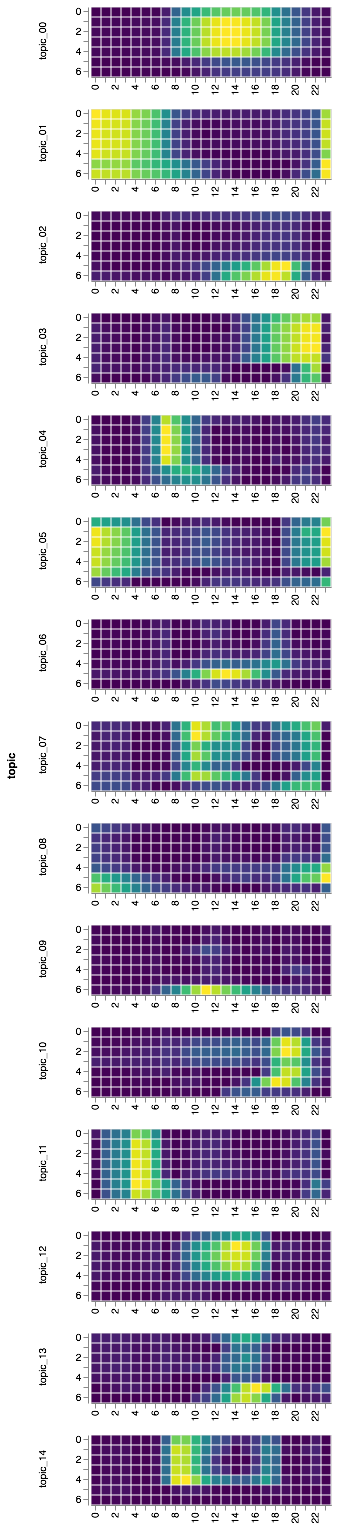

In [331]:
alt.Chart(df_topic)\
.mark_rect()\
.encode(
    alt.X('hour:O', axis=alt.Axis(title='')),
    alt.Y('day:O', axis=alt.Axis(title='')),
    color=alt.Color('score:Q', legend=None)
)\
.properties(width=240, height=70)\
.facet(row='topic:N')\
.resolve_scale(color='independent', x='independent')

# Where are the topics located?

In [269]:
census_topic = nmf.fit_transform(X)

In [270]:
df_census = pd.DataFrame(census_topic)
df_census.columns = ["topic_{}".format(i) for i in list(df_census.columns)]
df_census['census'] = list(X_df.index)
df_census['census'] = df_census['census'].apply(str)
df_census.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,census
0,0.604286,2.141932,1.193361,0.749687,0.514577,0.848665,0.073026,0.972816,0.287234,0.335130,0.034469,0.000000,0.034938,0.037647,0.113792,1101053010001
1,8.598227,9.093095,6.065517,4.516684,5.516515,3.926450,1.512918,5.769364,1.612882,2.460510,3.425922,3.658630,0.525016,0.059869,0.000000,1101053010002
2,6.901101,8.105571,6.164378,2.425936,4.164684,3.324070,1.016989,3.470678,1.286479,1.485724,1.289629,3.064000,4.514761,2.573346,1.216313,1101053010003
3,20.280056,6.618472,8.255636,8.452716,5.234318,4.943477,3.929608,3.181947,3.448282,2.124611,5.140533,1.790696,0.037120,4.369911,7.675357,1101053010004
4,18.401023,2.708611,3.332155,6.079045,5.131163,3.706513,0.821055,3.340141,2.844854,1.785445,2.132553,1.066055,0.614428,4.215758,0.422751,1101053010005


In [271]:
map_census = gpd.read_file("../data/raw/geo/census.shp")
map_census.head()

,TOT_REG_CD,ADM_NM,ADM_CD,geometry
0,1101053010006,사직동,1101053,"POLYGON ((953231.9682865143 1953435.865716934,..."
1,1101053010001,사직동,1101053,"POLYGON ((952858.5655841827 1952976.274114609,..."
2,1101053010003,사직동,1101053,"POLYGON ((952889.1776866913 1953405.245515823,..."
3,1101053010002,사직동,1101053,"POLYGON ((953093.8012866974 1953337.962316513,..."
4,1101053010005,사직동,1101053,"POLYGON ((953553.9324855804 1953335.741514206,..."


In [272]:
df_map = pd.merge(map_census, df_census, right_on='census', left_on='TOT_REG_CD')

In [273]:
df_map.head()

,TOT_REG_CD,ADM_NM,ADM_CD,geometry,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,census
0,1101053010006,사직동,1101053,"POLYGON ((953231.9682865143 1953435.865716934,...",1.781679,5.421152,0.835230,1.547685,1.547254,2.148108,0.153105,1.406963,1.511470,0.254853,1.094320,1.126498,0.000000,0.722377,0.464165,1101053010006
1,1101053010001,사직동,1101053,"POLYGON ((952858.5655841827 1952976.274114609,...",0.604286,2.141932,1.193361,0.749687,0.514577,0.848665,0.073026,0.972816,0.287234,0.335130,0.034469,0.000000,0.034938,0.037647,0.113792,1101053010001
2,1101053010003,사직동,1101053,"POLYGON ((952889.1776866913 1953405.245515823,...",6.901101,8.105571,6.164378,2.425936,4.164684,3.324070,1.016989,3.470678,1.286479,1.485724,1.289629,3.064000,4.514761,2.573346,1.216313,1101053010003
3,1101053010002,사직동,1101053,"POLYGON ((953093.8012866974 1953337.962316513,...",8.598227,9.093095,6.065517,4.516684,5.516515,3.926450,1.512918,5.769364,1.612882,2.460510,3.425922,3.658630,0.525016,0.059869,0.000000,1101053010002
4,1101053010005,사직동,1101053,"POLYGON ((953553.9324855804 1953335.741514206,...",18.401023,2.708611,3.332155,6.079045,5.131163,3.706513,0.821055,3.340141,2.844854,1.785445,2.132553,1.066055,0.614428,4.215758,0.422751,1101053010005


In [319]:
df_map.crs = "+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs"
df_map_wgs = df_map.to_crs({'init': 'epsg:4326'})
df_map_wgs.to_file("../data/processed/census-topic.geojson", driver="GeoJSON")

(933183.6392549515, 973919.1847883224, 1935149.4675004957, 1968503.2389585492)

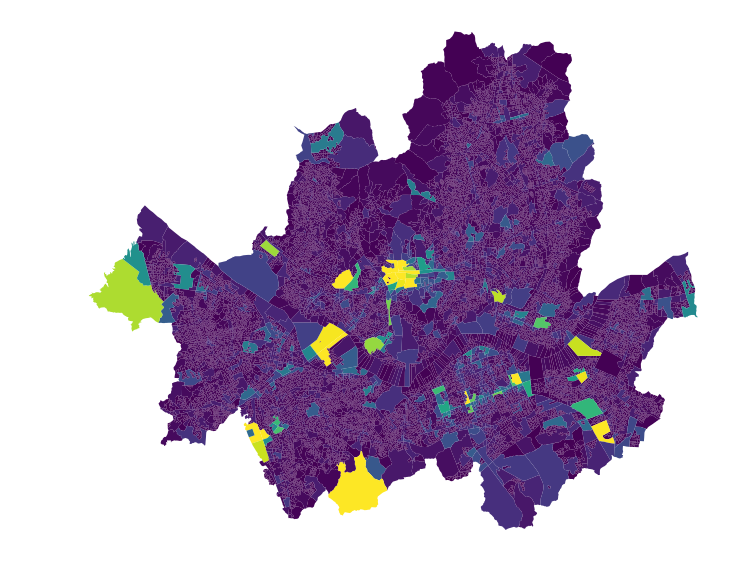

In [301]:
df_map.plot(column='topic_0', vmax=max(df_map['topic_0'])*0.3, figsize=(12,12))
plt.axis('off')

(933183.6392549515, 973919.1847883224, 1935149.4675004957, 1968503.2389585492)

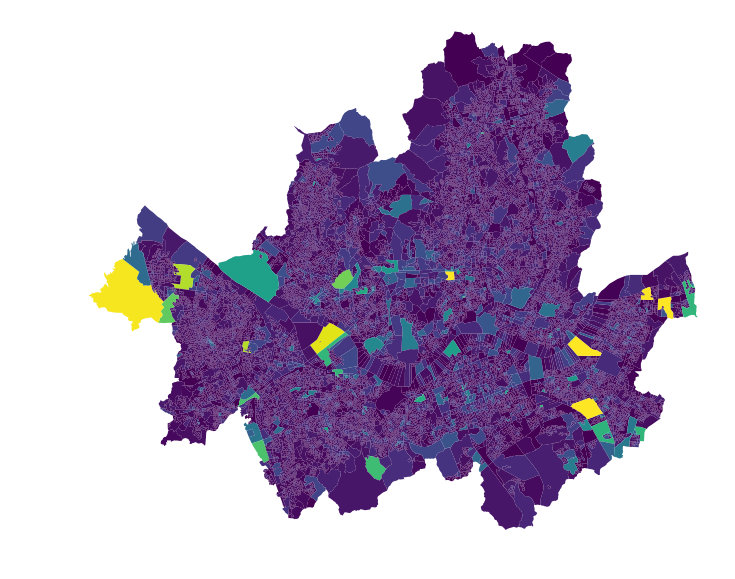

In [310]:
df_map.plot(column='topic_11', vmax=max(df_map['topic_11'])*0.5, figsize=(12,12))
plt.axis('off')

(933183.6392549515, 973919.1847883224, 1935149.4675004957, 1968503.2389585492)

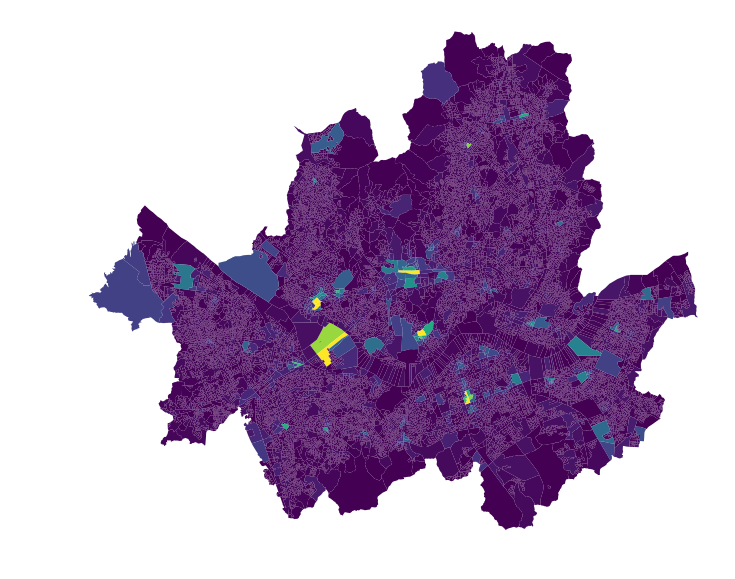

In [304]:
df_map.plot(column='topic_8', vmax=max(df_map['topic_8'])*0.5, figsize=(12,12))
plt.axis('off')

In [334]:
df_map.max(axis=0)

TOT_REG_CD    1125074033301
ADM_NM                  흑석동
ADM_CD              1125074
topic_0             370.829
topic_1             107.531
topic_2             93.3075
topic_3             60.0323
topic_4             90.8678
topic_5             255.206
topic_6             55.7344
topic_7             96.3772
topic_8             65.2142
topic_9             57.5409
topic_10            121.925
topic_11            57.2004
topic_12            193.619
topic_13            45.3794
topic_14            123.914
census        1125074033301
dtype: object